# Gradient Boosted Trees
Whereas random forests build an ensemble of deep,independent trees, GBMs build an ensemble of successive trees that shallow and weak, with each tree learning and improving on the previous tree. The model's combination of learners yield higher predictive accuray with minimal data pre-processing. However, the continuous improvement on subsequent learners can result in over-fitting and is computationally expensive. 

In [1]:
library(rsample)      # data splitting 
library(gbm)          # basic implementation
library(xgboost)      # a faster implementation of gbm
library(caret)        # an aggregator package for performing many machine learning models
library(h2o)          # a java-based platform
library(pdp)          # model visualization
library(ggplot2)      # model visualization
library(lime)         # model visualization

Loaded gbm 2.1.8

Loading required package: lattice

Loading required package: ggplot2


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




Boosting is a sequential process in which each next model which is generated is added so as to improve a bit from the previous collection of models. In Boosting we do weighted averaging. 
Boosting is leans more towards Bias i.e simple learners or more specifically Weak learners. A weak learner is a learner which always learns something i.e does better than chance and also has error rate less then 50%. The best example of a weak learner is a Decision tree, and is why we generally use decision trees to improve accuracy and performance. Using weak models allows the algorithm to learn slowly, making minor adjustments in different areas as the algorithm progresses.

## import data and check data attributes (NAs, column d_types, etc.)

In [2]:
ml_data <- read.csv('ml_predict_data.csv')

In [3]:
# assign countyname col to ml_data idx
row.names(ml_data) <- ml_data$X
# drop X col
drops <- c('X')
ml_data <- ml_data[, !(names(ml_data) %in% drops)]

Tree-based methods tend to perform well on unprocessed data (i.e. without normalizing, centering, scaling features). However, mmodel performance can potentially be improved by processing variable attributes.

In [4]:
# function to scale X
normalize <- function(x) {
    return((x - min(x))/(max(x) - min(x)))
}

In [5]:
set.seed(1)
# create an index to split the data to 80% training and 20% test
index = round(nrow(ml_data)*0.2,digits=0)
# sample randomly throughout the dataset 
test.indices = sample(1:nrow(ml_data), index)
#80% training set
train = ml_data[-test.indices,] 
#20% test set
test = ml_data[test.indices,] 

# apply the normalize function to normalize the data
train_x_scaled = data.frame(lapply(train[, 2:21], normalize))
train_y = train[,1]

# apply the normalize function to normalize the data
test_x_scaled = data.frame(lapply(test[, 2:21], normalize))
test_y = test[,1]

In [6]:
# subset ml_data to train
training <- cbind(train_x_scaled, train_y)
names(training)[names(training) == 'train_y'] <- 'avg_perc_change_emp'

# subset the rest to test
testing <- cbind(test_x_scaled, test_y)
names(testing)[names(testing) == 'test_y'] <- 'avg_perc_change_emp'

## hyperparameter tuning
The array of hyperparameters available with the GBM model is both a blessing and a curse. Additional hyperparameters make the GBM model highly flexible. However, theye also add complexity to the tuning process. Hyperparameters commonly encountered in most GBM implementations include:
 - **number of trees**: this hyperparameter specifies the total number of trees to fit. GBM's often require many trees. however, including too many trees can result in overfitting. It's therefore important to find the optimal number of trees.
 
 - **tree depth**: the number of splits (d) in each tree, which controls the complexity of the boosted ensemble. as the algorithm looks to implement weak learners, a d of 1 will often suffice, in which case each tree is a stump consisting of a single split. it's unlikely that d will exceed 10.
 
 - **learning rate**: the rate at which the algorithm engages in gradient descent. smaller values increase the time it takes for the model to find the optimal fit, while reducing the probability of overfitting.
 
 - **subsamppling**: the fraction of available training observations the algorithm uses. stochastic gradient descent is implemented when less than 100% of all available training observations are used. 
 
Stochastic Gradient descent can be helpful in handling local minimas, plateaus and other irregularities found in the loss function of choice. These can make finding the global minimum difficult, but when sampling a fraction of the training observations (typically without replacement) and growing the next tree using that subsample, algorithm performance is improved. Furthermore, the stochastic nature of random sampling also adds some randomness to the path taken by the gradient descent algorithm as it descends the loss function gradient.

In [7]:
# create hyperparameter grid
hyper_grid <- expand.grid(
  shrinkage = c(.2, .25, .3),
  interaction.depth = c(4, 5, 6),
  n.minobsinnode = c(10, 15, 20),
  bag.fraction = c(.75, .8, .85), 
  optimal_trees = 0,
  min_RMSE = 0         
)

# total number of combinations
nrow(hyper_grid)

[1] 81

## grid search

In [8]:
# randomize data
random_index <- sample(1:nrow(ml_data), nrow(ml_data))
random_employ_train <- ml_data[random_index, ]

# grid search 
for(i in 1:nrow(hyper_grid)) {
  
  # reproducibility
  set.seed(1)
  
  # train model
  gbm.tune <- gbm(
    formula = avg_perc_change ~ .,
    distribution = "gaussian",
    data = random_employ_train,
    n.trees = 9000,
    interaction.depth = hyper_grid$interaction.depth[i],
    shrinkage = hyper_grid$shrinkage[i],
    n.minobsinnode = hyper_grid$n.minobsinnode[i],
    bag.fraction = hyper_grid$bag.fraction[i],
    train.fraction = .75,
    n.cores = NULL, # will use all cores by default
    verbose = FALSE
  )
  
  # add min training error and trees to grid
  hyper_grid$optimal_trees[i] <- which.min(gbm.tune$valid.error)
  hyper_grid$min_RMSE[i] <- sqrt(min(gbm.tune$valid.error))
}

hyper_grid %>% 
  dplyr::arrange(min_RMSE) %>%
  head(10)

,shrinkage,interaction.depth,n.minobsinnode,bag.fraction,optimal_trees,min_RMSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.20,5,15,0.75,4,0.1388640
2,0.25,5,15,0.80,5,0.1396760
3,0.30,5,15,0.80,7,0.1399514
4,0.25,5,15,0.75,3,0.1399552
5,0.25,4,15,0.80,5,0.1403190
6,0.20,5,15,0.80,5,0.1403650
7,0.25,4,20,0.80,4,0.1406007
8,0.20,6,15,0.75,4,0.1407905
9,0.25,6,15,0.75,3,0.1408451


## train the gradient boosted model
1) fit a decision tree to the data<br>
2) fit the next decision tree to the residuals of the previous and add this new tree to the total trees considered<br>
3) fit the next decision tree using the residuals of the total trees considered by the algorithm<br>
4) continue until some mechanism tells the algorithm to stop training new trees<br>

In [9]:
gbm.fit = gbm(
    avg_perc_change_emp ~ ., 
    data = training, 
    distribution = "gaussian",
    n.trees = 10000, # the total number of trees
    shrinkage = 0.25, # the learning rate (a small learning rate requires many trees)
    interaction.depth = 4, # the total splits in each tree
    n.minobsinnode = 15, # the minimum number of observations allowed in tree leaf nodes
    bag.fraction = 0.85, # less than 1.0 introduces stochastic gradient descent
    train.fraction = 1,
    cv.folds = 5, # perform cross-validation
    n.cores = NULL, # will use all cores by default
)

[1] 4

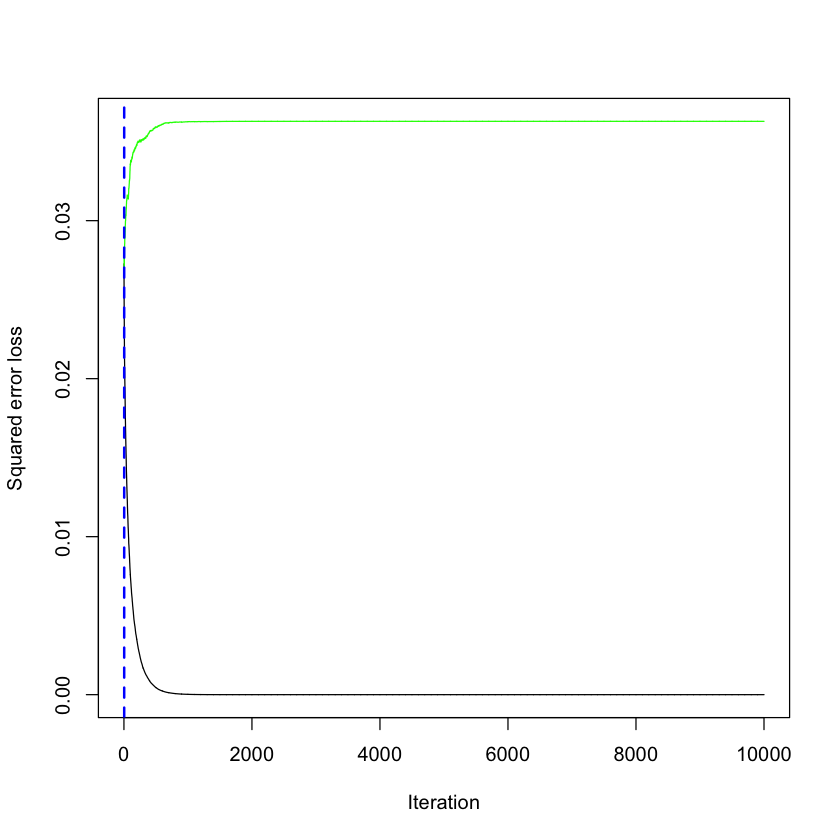

In [10]:
gbm.perf(gbm.fit, method = "cv")

## Feature Importance Plot
What features have the largest influence on the average percent change in the employment rate seen per county?

The default method for computing feature importance is the relative influence method. This method works by computing the improvement made in the split-criterion (MSE for regression) at each split in each tree. The improvements made by each feature across all the trees are then averaged. The features with the largest average decrease in MSE are considered to be the most important features.

,var,rel.inf
,<chr>,<dbl>
nonelder,nonelder,12.324093
new_case_count_sum,new_case_count_sum,9.047065
state,state,6.489965
voteage,voteage,6.433433
genderincome,genderincome,6.350601
religion,religion,5.525349
local,local,4.995046
education,education,4.994852
federal,federal,4.498455


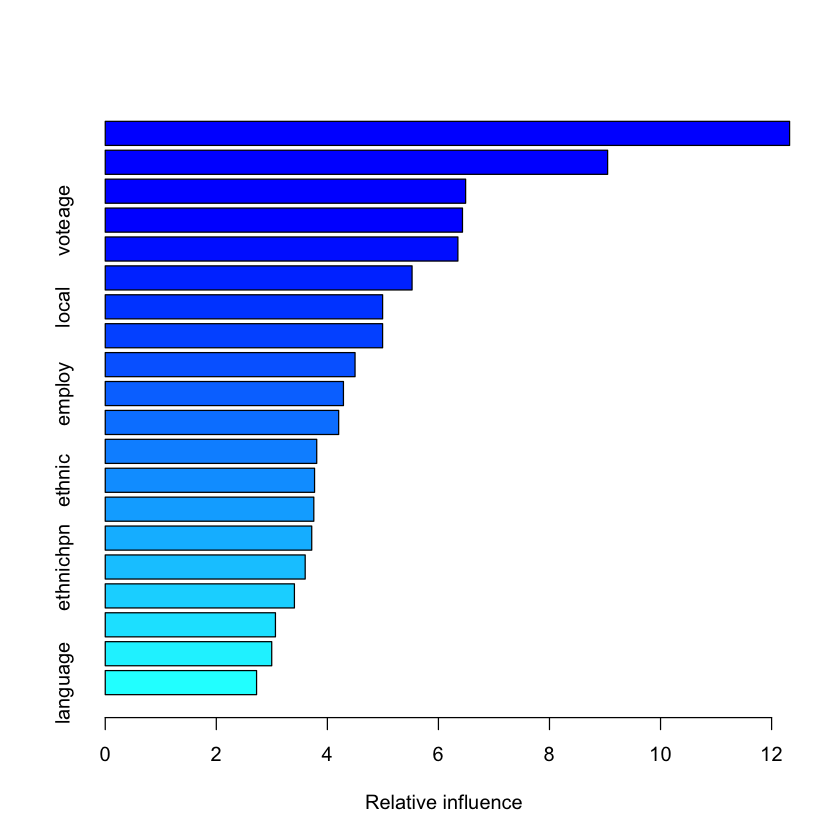

In [11]:
# summary gives a table of Variable Importance (from most to least important) 
# and a plot of Variable Importance
summary(gbm.fit)

## Partial Dependence Plot
plots the average marginal effect on the response variable and aids in helping to understand how the response variable changes based on changes in the indicated feature

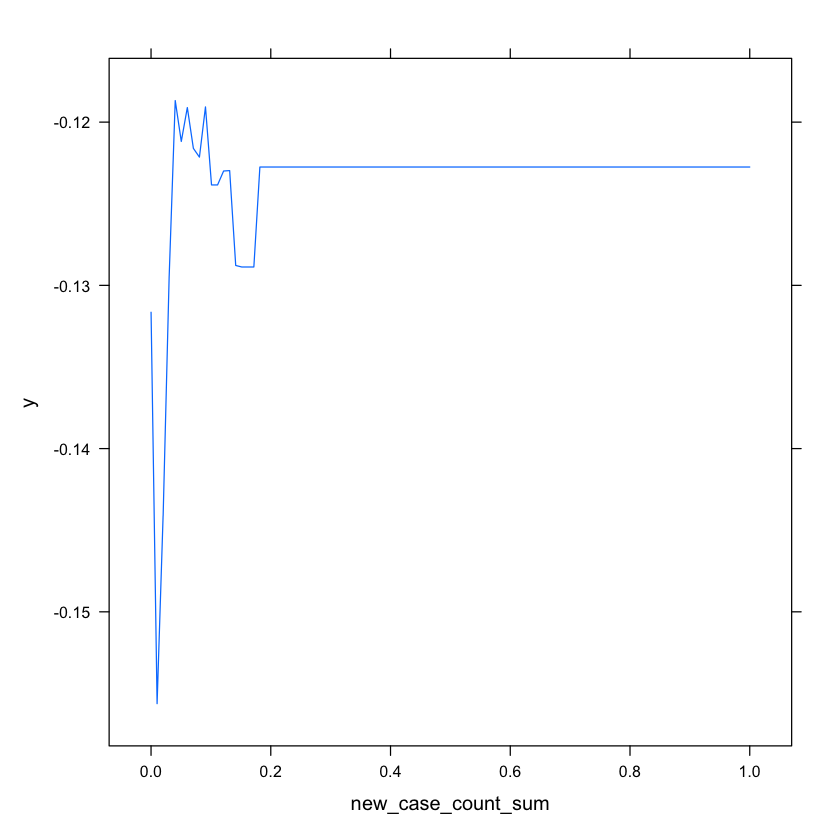

In [12]:
plot(gbm.fit,i="new_case_count_sum") 
# direct relation with avg_perc_change

In [13]:
cor(ml_data$avg_perc_change, ml_data$new_case_count_sum) # slight positive correlation coeff-r

[1] 0.006875771

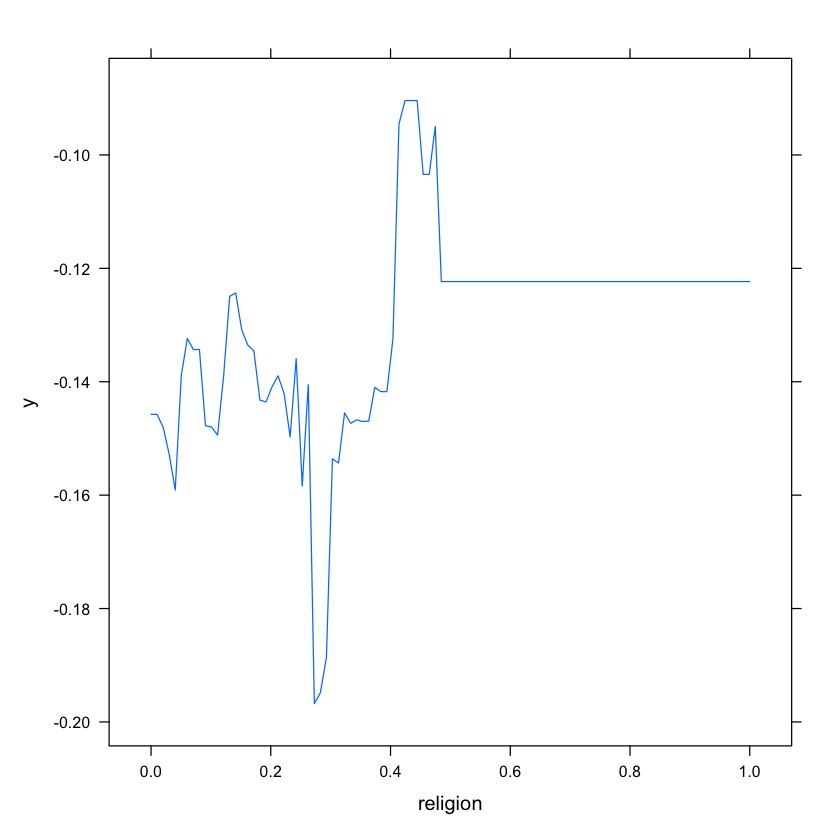

In [14]:
plot(gbm.fit,i="religion") 
# inverse relation with avg_perc_change variable

In [15]:
cor(ml_data$avg_perc_change, ml_data$religion) # negetive correlation coeff-r

[1] -0.1565462

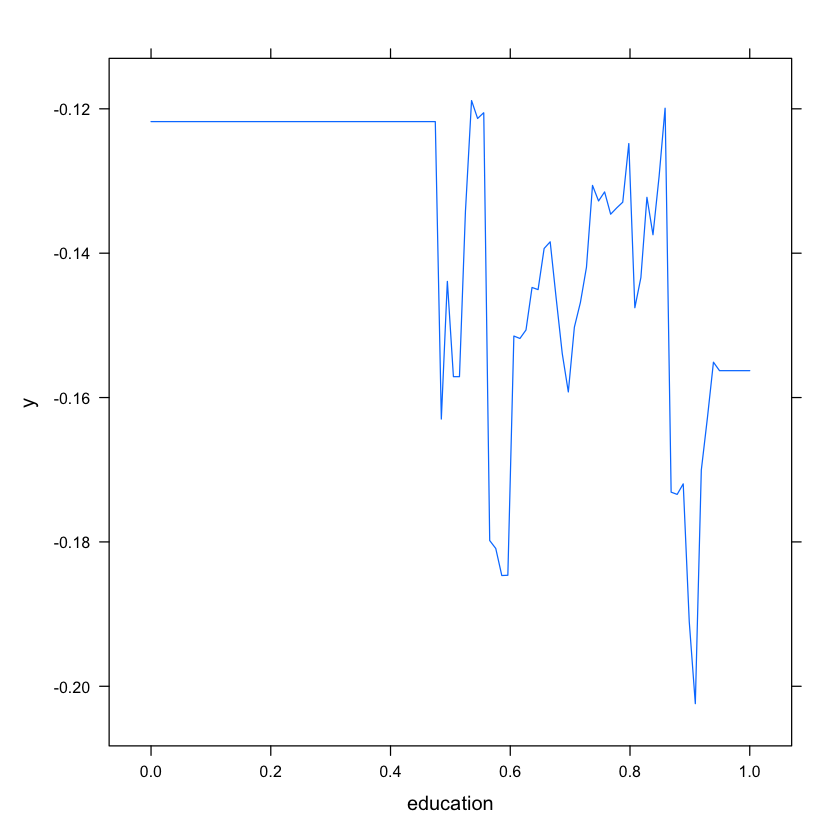

In [16]:
plot(gbm.fit,i="education") 
# direct relation with avg_perc_change variable

In [17]:
cor(ml_data$avg_perc_change, ml_data$education) # positive correlation coeff-r

[1] 0.06303116

# final gbm fit

In [18]:
# for reproducibility
set.seed(1)

gbm.fit.final = gbm(
    avg_perc_change_emp ~ ., 
    data = training, 
    distribution = "gaussian",
    n.trees = 742, # the total number of trees
    shrinkage = 0.25, # the learning rate (a small learning rate requires many trees)
    interaction.depth = 4, # the total splits in each tree
    n.minobsinnode = 15, # the minimum number of observations allowed in tree leaf nodes
    bag.fraction = 0.85, # less than 1.0 introduces stochastic gradient descent
    train.fraction = 1,
    n.cores = NULL, # will use all cores by default
)

# making predictions

In [19]:
# predict values for test data
pred <- predict(gbm.fit.final, n.trees = gbm.fit.final$n.trees, testing)

## MSE
GBM is a gradient descent algorithm. Gradient descent can be performed on any loss function that is differentiable and therefore, can optimize different loss functions. Here, we use the MSE loss function.

## RSME

## manual calculation

In [20]:
rmse = function(actual, predicted) {
  sqrt(mean((actual - predicted) ^ 2))
}

In [21]:
rmse(testing$avg_perc_change_emp, pred)

[1] 0.1829751

## using caret package calculation

In [22]:
# results
caret::RMSE(pred, testing$avg_perc_change_emp)

[1] 0.1829751

# roc_auc_score for regression problems?
https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb

# naive_roc_auc_score
Thanks to Samuele Mazzanti's article, we are able to understand how our algorithm is performing in another way. 
Here, the roc_auc_score coincides with “the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one”. In other words, if we take any two observations a and b such that a > b, then roc_auc_score is equal to the probability that our model actually ranks a higher than b.

In [23]:
naive_roc_auc_score <- function(y_true, y_pred) {
    num_same_sign <- 0
    num_pairs <- 0 
    
    for(a in 1:length(y_true))
    {
        for(b in 1:length(y_true))
        {
            if (y_true[a] > y_true[b]) {
                
                num_pairs <- num_pairs + 1
                
                if (y_pred[a] > y_pred[b]) {
                
                    num_same_sign <- num_same_sign + 1
                }
                else if (y_pred[a] == y_pred[b]) {
                    
                    num_same_sign <- num_same_sign + .5
                }
            }
        }
    }
    num_same_sign / num_pairs
}

In [24]:
naive_roc_auc_score(testing$avg_perc_change_emp, pred)

[1] 0.5481299

# Sources
https://datascienceplus.com/gradient-boosting-in-r/
http://uc-r.github.io/gbm_regression